In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from importkickdata import loadkickdata

# Function loads and cleans kicking data from profootballreference.com
#kicks = loadkickdata('kickingdata.csv')

In [173]:
kicks = pd.read_csv('kickingdata.csv', header=0)

# Rename column containing an @ symbol if the kicking team is the away team.
kicks.rename(columns={'Unnamed: 3':'At'}, inplace=True)

# Delete index column in csv
del kicks['Rk']

# Create boolean column if kicking team is the home team
kicks['Home'] = (kicks['At'] != '@')

# Isolate unique player id
kicks['PlayerID'] = kicks['Player'].apply(lambda x: str.split(x, '\\')[1])

# Create variable for team whose stadium the game is played at
kicks['Stadium'] = kicks.apply(lambda x: [x['Opp'],x['Tm']][x['Home']], axis='columns')

# Reformat 'Good?' column to be a boolean
kicks['Good?'] = (kicks['Good?']=='Y')

# Reformat blocked kick column to be a boolean
kicks['Blk?'] = (kicks['Blk?']=='Y')

# Function to convert date from the given format (a string with the format mm/dd/yy) 
# to python date format.
def convert_date(x):
    x = x.split('/')
    return datetime.date(int('20'+x[2]), int(x[0]), int(x[1]))

# Reformat date column
kicks['Date'] = kicks['Date'].apply(convert_date)

# Create variable for distance squared
kicks['Dist_sq'] = kicks['Dist'].apply(lambda x: x**2)

# Create variable for season of kick
kicks['Season'] = kicks['Date'].apply(lambda x: x.year)

# Create month variable
kicks['Month'] = kicks['Date'].apply(lambda x: x.month)


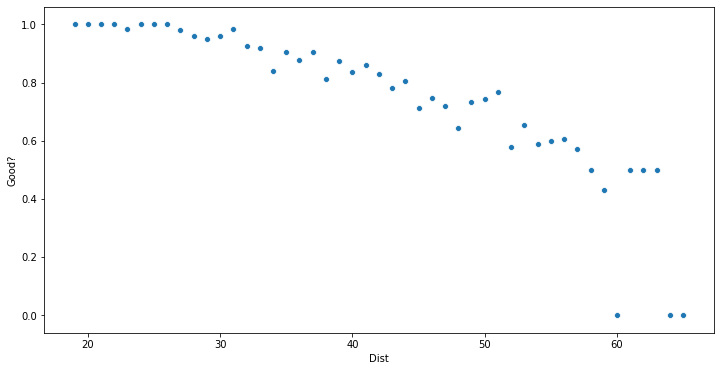

In [162]:
# Create scatter plot displaying success rate by distance of kick
bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
plt.show()

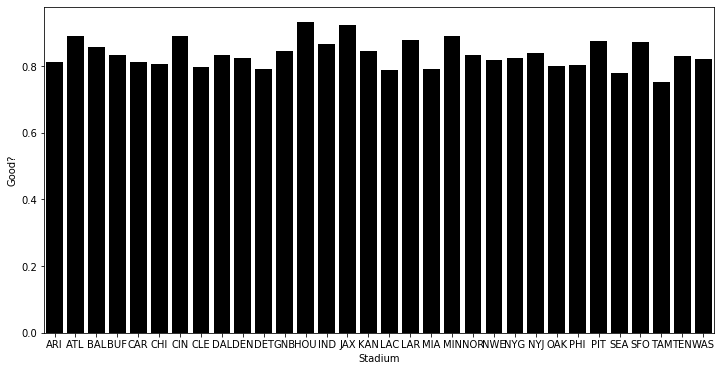

In [163]:
bystadium = kicks.groupby(['Stadium']).mean()

plt.figure(figsize=(12,6))
sns.barplot(bystadium.index, bystadium['Good?'], color='black')
plt.show()

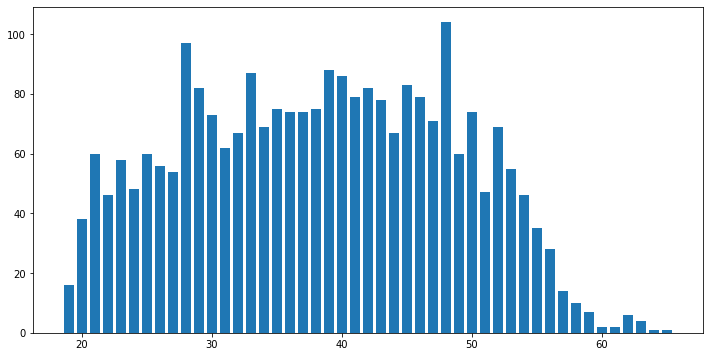

In [164]:
plt.figure(figsize=(12,6))
plt.bar(kicks['Dist'].value_counts().sort_index().index, kicks['Dist'].value_counts().sort_index())
plt.show()

In [165]:
kicks.columns

Index(['Date', 'Tm', 'At', 'Opp', 'Result', 'Player', 'Dist', 'Good?', 'Blk?',
       'Home', 'PlayerID', 'Stadium', 'Dist_sq', 'Season'],
      dtype='object')

In [176]:
y = kicks['Good?']
X = kicks[['Dist', 'Dist_sq']]

probit = sm.Probit(y, X)
probit_res = probit.fit()
probit_me = probit_res.get_margeff()
probit_me.summary()

Optimization terminated successfully.
         Current function value: 0.394551
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                  Good?
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Dist           0.0239      0.001     42.928      0.000       0.023       0.025
Dist_sq       -0.0004   1.44e-05    -30.168      0.000      -0.000      -0.000
==============================================================================
"""

In [177]:
kicks['Kick prob'] = probit_res.predict(kicks[['Dist', 'Dist_sq']])

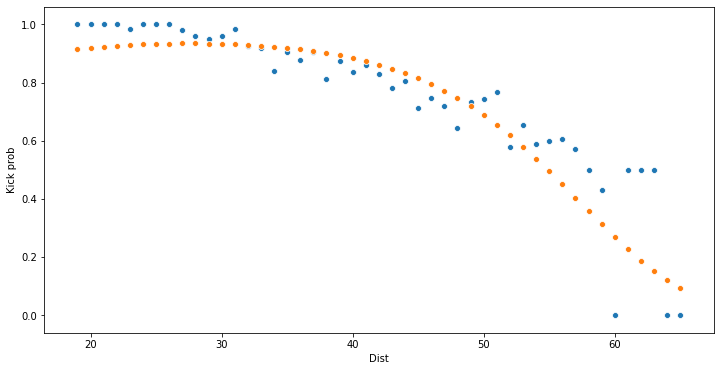

In [168]:
bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob'])

plt.show()

Optimization terminated successfully.
         Current function value: 0.511506
         Iterations 4


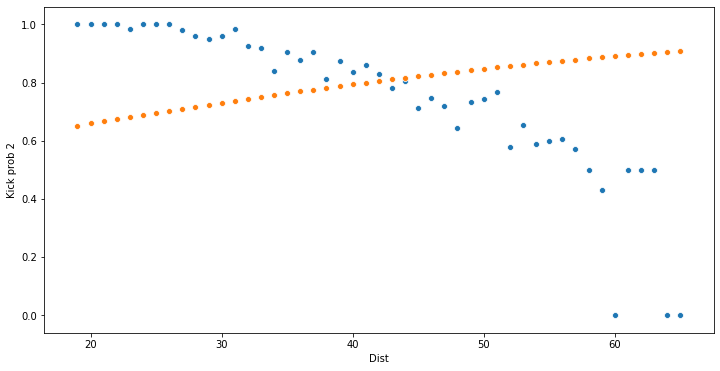

In [169]:
y = kicks['Good?']
X = kicks['Dist']

probit = sm.Probit(y, X)
probit_res = probit.fit()
probit_me = probit_res.get_margeff()
probit_me.summary()

kicks['Kick prob 2'] = probit_res.predict(kicks['Dist'])

bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob 2'])

plt.show()

In [170]:
y = kicks['Good?']
X = kicks[['Dist', 'Dist_sq', 'Dist_cu']]

probit = sm.Probit(y, X)
probit_res = probit.fit()
probit_me = probit_res.get_margeff()
probit_me.summary()

kicks['Kick prob 2'] = probit_res.predict(kicks[['Dist', 'Dist_sq', 'Dist_cu']])

bydistance = kicks.groupby(['Dist']).mean()

plt.figure(figsize=(12,6))
sns.scatterplot(bydistance.index, bydistance['Good?'])
sns.scatterplot(bydistance.index, bydistance['Kick prob 2'])

plt.show()

KeyError: "['Dist_cu'] not in index"

In [178]:
playerstats = kicks.groupby(['PlayerID']).mean()
playerstats['Percent differential'] = playerstats['Good?'] - playerstats['Kick prob']
playerstats['Percent differential'].nlargest(10)

PlayerID
SeibAu00      0.115232
TuckJu00      0.109701
GanoGr44      0.092020
LambJo00      0.090901
HekkJo00      0.080608
ZuerGr00      0.066458
PratMa20      0.065297
BadgMi00      0.055633
bryanmat01    0.054809
GayxMa00      0.042588
Name: Percent differential, dtype: float64

In [183]:
shaus = kicks[kicks['PlayerID'] == 'HausSt00']
shaus.groupby(['Season', 'Month']).mean().loc[:,['Dist', 'Good?', 'Kick prob']]

Dist     Good?  Kick prob
Season Month                                
2017   9      45.833333  0.833333   0.722397
       10     38.250000  0.916667   0.812590
       11     46.333333  0.833333   0.717448
       12     36.888889  0.888889   0.848843
2018   9      41.833333  0.833333   0.813071
       10     41.857143  1.000000   0.796282
       11     37.000000  1.000000   0.817356
       12     40.636364  0.545455   0.814561
2019   9      46.500000  0.666667   0.714010
       10     45.000000  0.750000   0.783398
       11     43.000000  0.333333   0.787776

In [186]:
shaus.groupby(['Season']).count()

,Date,Tm,At,Opp,Result,Player,Dist,Good?,Blk?,Home,PlayerID,Stadium,Dist_sq,Month,Kick prob
Season,,,,,,,,,,,,,,,
2017,33,33,19,33,33,33,33,33,33,33,33,33,33,33,33
2018,28,28,14,28,28,28,28,28,28,28,28,28,28,28,28
2019,13,13,3,13,13,13,13,13,13,13,13,13,13,13,13


In [259]:
shaus19 = shaus[shaus.Season==2019]

In [257]:
c = .75
kicksim = pd.DataFrame(np.random.choice([0,1], p=[c,1-c], size=20))
c = .8
#kicksim = pd.concat([kicksim, pd.Series(np.random.choice([0,1], p=[c,1-c], size=20))])
kicksim.assign(new = pd.Series(np.random.choice([0,1], p=[c,1-c], size=20)))

print()

In [272]:
kicksim = pd.DataFrame()
probs = list(shaus19['Kick prob'])
for i in range(13):
    col_name = 'kick ' + str(i+1)
    kicksim[col_name] = pd.Series(np.random.choice([1,0], p=[probs[i],1-probs[i]], size=1000))

In [273]:
kicksim.describe()

,kick 1,kick 2,kick 3,kick 4,kick 5,kick 6,kick 7,kick 8,kick 9,kick 10,kick 11,kick 12,kick 13
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.927000,0.590000,0.883000,0.605000,0.891000,0.826000,0.838000,0.705000,0.803000,0.198000,0.811000,0.925000,0.839000
std,0.260267,0.492079,0.321581,0.489095,0.311795,0.379299,0.368635,0.456271,0.397931,0.398692,0.391705,0.263523,0.367715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [274]:
probs

[0.9230020276132196,
 0.5790507892254952,
 0.8612762936604024,
 0.5790507892254952,
 0.8931598179201108,
 0.8139315722722535,
 0.8474499052109896,
 0.7184052352980372,
 0.7938668668369488,
 0.18740517931911904,
 0.8139315722722535,
 0.9230020276132196,
 0.8474499052109896]

In [276]:
sum(shaus19['Good?'])

8

In [292]:
kicksim['Kicks made'] = 0

for k in range(kicksim.shape[0]):
    kicksim.loc[k, 'Kicks made'] = sum(kicksim.iloc[k,:])



#sum(kicksim.iloc[1,:])

<BarContainer object of 8 artists>

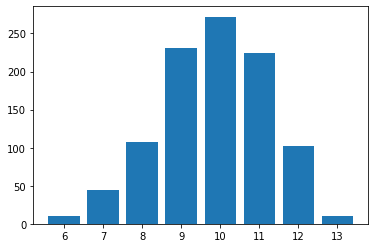

In [299]:
plt.bar(kicksim['Kicks made'].value_counts().index, kicksim['Kicks made'].value_counts())

In [301]:
kicksim[kicksim['Kicks made'] <= 8].shape[0]

161